# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings("ignore")
#application_train = pd.read_csv('/content/drive/MyDrive/application_train.csv')

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/content/drive/MyDrive/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('/content/drive/MyDrive/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/content/drive/MyDrive/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('/content/drive/MyDrive/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [ ]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/content/drive/MyDrive/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/content/drive/MyDrive/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
 

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/content/drive/MyDrive/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/content/drive/MyDrive/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [ ]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df.to_csv('/content/drive/MyDrive/P7_Preprocessed.csv')

if __name__ == "__main__":
#    submission_file_name = "submission_kernel02.csv"
   with timer("Full model run"):
        main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 30s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 28s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 16s
Installments payments df shape: (339587, 26)
Process installments payments - done in 38s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 238s
Full model run - done in 360s


# Feature Selection

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/P7_Preprocessed.csv')

In [ ]:
application_train = df

In [ ]:
application_train.shape

(356251, 799)

In [ ]:
application_train.head()

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,0,100002,1.0,0,0,0,0,202500.0,406597.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,100004,0.0,0,1,0,0,67500.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,100006,0.0,1,0,0,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,4,100007,0.0,0,0,0,0,121500.0,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
application_train = application_train.drop(columns=['Unnamed: 0', 'index'])

In [ ]:
application_sample1 = application_train.loc[application_train.TARGET==1].sample(frac=0.1, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))
application_sample0 = application_train.loc[application_train.TARGET==0].sample(frac=0.1, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))
application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('SK_ID_CURR')

label 1 sample size: 2482
label 0 sample size: 28268


In [ ]:
categorical_list = []
numerical_list = []
for i in application.columns.tolist():
    if application[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 0
Number of numerical features: 797


In [ ]:
# Replace infinite updated data with nan
application.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
from sklearn import impute
from sklearn.impute import SimpleImputer

application[numerical_list] = SimpleImputer(strategy='median').fit_transform(application[numerical_list])

del application_train; gc.collect()
application = pd.get_dummies(application, drop_first=True)
print(application.shape)

(30750, 797)


In [ ]:
X = application.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = application.TARGET
feature_name = X.columns.tolist()

In [ ]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [ ]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


In [ ]:
#def scaler(X):
  
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
  
#  return X_norm

In [ ]:
#def chi(X_norm, y):

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
  
 # return chi_support

100 selected features


In [ ]:
#def rfe(X_norm, y):

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=53, verbose=5)
rfe_selector.fit(X_norm, y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=100, step=10, verbose=5)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

#  return rfe_support

Fitting estimator with 795 features.
Fitting estimator with 742 features.
Fitting estimator with 689 features.
Fitting estimator with 636 features.
Fitting estimator with 583 features.
Fitting estimator with 530 features.
Fitting estimator with 477 features.
Fitting estimator with 424 features.
Fitting estimator with 371 features.
Fitting estimator with 318 features.
Fitting estimator with 265 features.
Fitting estimator with 212 features.
Fitting estimator with 159 features.
Fitting estimator with 106 features.
100 selected features


In [ ]:
#def lr_selector (X_norm, y):
  
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2")).fit(X_norm, y)
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

#  return embeded_lr_support

298 selected features


In [ ]:
#def rfc(X, y):

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X_norm, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
  
#  return embeded_rf_support

356 selected features


In [ ]:
#def LGBM(X, y):

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X_norm, y)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')
  
#  return embeded_lgb_support

391 selected features


In [ ]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN,True,True,True,True,True,True,6
2,EXT_SOURCE_3,True,True,True,True,True,True,6
3,EXT_SOURCE_2,True,True,True,True,True,True,6
4,EXT_SOURCE_1,True,True,True,True,True,True,6
5,CC_CNT_DRAWINGS_CURRENT_MEAN,True,True,True,True,True,True,6
6,APPROVED_DAYS_DECISION_MIN,True,True,True,True,True,True,6
7,REGION_RATING_CLIENT_W_CITY,True,True,False,True,True,True,5
8,REGION_RATING_CLIENT,True,True,False,True,True,True,5
9,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN,True,True,True,True,False,True,5
10,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,True,True,False,True,True,True,5


In [ ]:
test_df = application[['SK_ID_CURR', 'TARGET','PREV_CODE_REJECT_REASON_HC_MEAN', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED_PERC', 'CC_CNT_DRAWINGS_POS_CURRENT_MAX', 
                       'CC_CNT_DRAWINGS_CURRENT_MAX', 'BURO_STATUS_1_MEAN_MEAN', 'REGION_RATING_CLIENT', 'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN', 'PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN', 
                       'PREV_NAME_YIELD_GROUP_low_action_MEAN', 'PREV_NAME_YIELD_GROUP_high_MEAN', 'PREV_NAME_YIELD_GROUP_XNA_MEAN','PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN','PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
                       'PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN','PREV_CODE_REJECT_REASON_SCOFR_MEAN','PREV_AMT_ANNUITY_MIN','PREV_AMT_ANNUITY_MEAN','DEF_30_CNT_SOCIAL_CIRCLE','DAYS_ID_PUBLISH',
                       'CC_CNT_DRAWINGS_ATM_CURRENT_SUM','CC_CNT_DRAWINGS_ATM_CURRENT_MEAN','CC_AMT_DRAWINGS_ATM_CURRENT_MEAN','BURO_CREDIT_ACTIVE_Active_MEAN','APPROVED_AMT_ANNUITY_MEAN','APPROVED_AMT_ANNUITY_MAX',
                       'AMT_GOODS_PRICE','REG_CITY_NOT_WORK_CITY','REGION_RATING_CLIENT_W_CITY','REFUSED_AMT_ANNUITY_MEAN','PREV_PRODUCT_COMBINATION_Card Street_MEAN','PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
                       'PREV_NAME_PAYMENT_TYPE_XNA_MEAN','PREV_NAME_GOODS_CATEGORY_Furniture_MEAN','PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN','PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
                       'PREV_NAME_CONTRACT_STATUS_Approved_MEAN','PREV_CNT_PAYMENT_SUM','PREV_AMT_ANNUITY_MAX','POS_SK_DPD_MAX','POS_NAME_CONTRACT_STATUS_Signed_MEAN','POS_MONTHS_BALANCE_SIZE','POS_COUNT',
                       'NONLIVINGAREA_MODE','INSTAL_PAYMENT_DIFF_SUM','INSTAL_PAYMENT_DIFF_MEAN','INSTAL_PAYMENT_DIFF_MAX','INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE','INSTAL_DBD_SUM','INSTAL_DBD_MAX',
                       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN','INSTAL_DAYS_ENTRY_PAYMENT_MAX','INSTAL_AMT_PAYMENT_MIN','INSTAL_AMT_PAYMENT_MEAN','INSTAL_AMT_PAYMENT_MAX','INSTAL_AMT_INSTALMENT_MEAN',
                       'INSTAL_AMT_INSTALMENT_MAX','INCOME_CREDIT_PERC','FLAG_DOCUMENT_3','DAYS_EMPLOYED','DAYS_BIRTH','CODE_GENDER','CNT_CHILDREN','CC_CNT_DRAWINGS_CURRENT_VAR','CC_AMT_TOTAL_RECEIVABLE_MEAN',
                       'CC_AMT_TOTAL_RECEIVABLE_MAX','CC_AMT_RECEIVABLE_PRINCIPAL_MAX','CC_AMT_BALANCE_MEAN','CC_AMT_BALANCE_MAX','BURO_MONTHS_BALANCE_SIZE_MEAN','BURO_MONTHS_BALANCE_MIN_MIN','BURO_DAYS_CREDIT_MIN',
                       'BURO_DAYS_CREDIT_MEAN','BURO_DAYS_CREDIT_MAX','BURO_CREDIT_TYPE_Credit card_MEAN','BURO_CREDIT_TYPE_Car loan_MEAN','BURO_CREDIT_ACTIVE_Closed_MEAN','BURO_AMT_CREDIT_SUM_MEAN',
                       'BURO_AMT_CREDIT_SUM_LIMIT_SUM','BURO_AMT_CREDIT_SUM_LIMIT_MEAN','BURO_AMT_CREDIT_SUM_DEBT_SUM','APPROVED_HOUR_APPR_PROCESS_START_MAX','APPROVED_DAYS_DECISION_MIN','APPROVED_DAYS_DECISION_MEAN',
                       'APPROVED_CNT_PAYMENT_SUM','APPROVED_AMT_CREDIT_MAX','ANNUITY_INCOME_PERC','AMT_INCOME_TOTAL','AMT_ANNUITY','ACTIVE_DAYS_CREDIT_VAR','ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_MAX',
                       'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN','ACTIVE_AMT_CREDIT_SUM_DEBT_SUM']]

In [ ]:
feature_selection_df = feature_selection_df.loc[feature_selection_df['Total'] > 3]

feature_selection_df = feature_selection_df.drop(columns=['Pearson',	'Chi-2',	'RFE',	'Logistics',	'Random Forest',	'LightGBM',	'Total'])

feature_selection_df.to_csv('/content/drive/MyDrive/P7_Features.csv')

In [ ]:
feature_selection_df.head()

,Feature
1,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN
2,EXT_SOURCE_3
3,EXT_SOURCE_2
4,EXT_SOURCE_1
5,CC_CNT_DRAWINGS_CURRENT_MEAN


In [ ]:
application.to_csv('/content/drive/MyDrive/P7_application_data.csv')

In [ ]:
test_df.to_csv('/content/drive/MyDrive/P7_test_df.csv')

# Machine Learning Testing

In [ ]:
!pip install -q shap lime #umap-learn lime

     |████████████████████████████████| 569 kB 3.9 MB/s 
     |████████████████████████████████| 275 kB 43.1 MB/s 


In [ ]:
#@title
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from imblearn.under_sampling import RandomUnderSampler
import pickle

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

#import shap
#from lime.lime_tabular import LimeTabularExplainer
import xgboost
import seaborn as sns; 
#import umap 

 
import matplotlib.pyplot as plt
import matplotlib 

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/P7_test_df.csv')

test_df = test_df.drop(columns=['Unnamed: 0'])

In [ ]:
test_df['TARGET'].value_counts()

0.0    28268
1.0     2482
Name: TARGET, dtype: int64

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
shap.initjs()

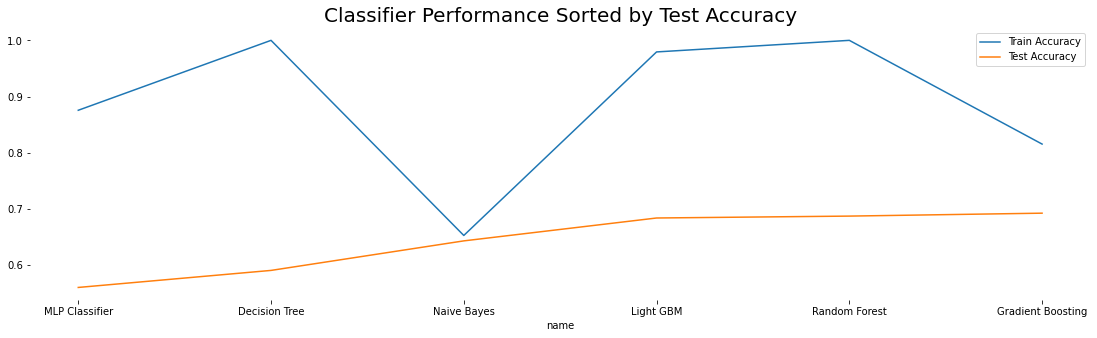

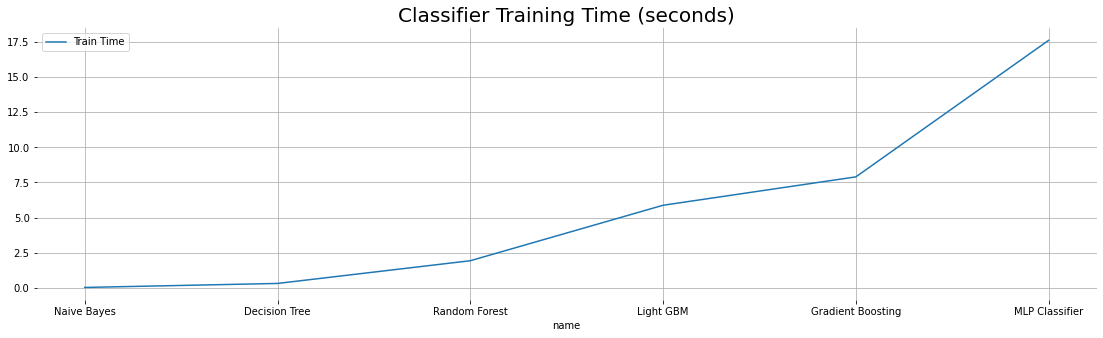

In [ ]:
features = test_df.drop(['TARGET'], axis=1)
labels = test_df['TARGET']

trained_models = [] #  keep track of all details for models we train

def train_model(model, features, labels): 
  X = features
  y = labels.values

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  undersample = RandomUnderSampler(sampling_strategy=1)
  X_train, y_train = undersample.fit_resample(X_train, y_train)

  pipe = Pipeline([('scaler', StandardScaler()), ('clf', model["clf"])])
  start_time = time.time()
  pipe.fit(X_train, y_train)
  train_time = time.time() - start_time

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 
  model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
  return model_details

models = [
          {"name": "Naive Bayes", "clf": GaussianNB()},
          {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
          {"name": "Random Forest", "clf": RandomForestClassifier(n_estimators=100)},
          {"name": "Gradient Boosting", "clf": GradientBoostingClassifier(n_estimators=100)}, 
          {"name": "Light GBM", "clf":LGBMClassifier(n_estimators=100)},
          {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, hidden_layer_sizes=(10,10,5,2), max_iter=500, random_state=42)}]

for model in models:
  model_details = train_model(model, features, labels) 
  trained_models.append(model_details)


# visualize accuracy and run time
#setup_plot()
model_df = pd.DataFrame(trained_models)
model_df.sort_values("test_accuracy", inplace=True) 
ax = model_df[["train_accuracy","test_accuracy", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False) 

In [ ]:
model_df

,name,train_accuracy,test_accuracy,train_time,model
0,Naive Bayes,0.652846,0.643210,0.025910,"(StandardScaler(), GaussianNB())"
1,Decision Tree,1.000000,0.590661,0.310868,"(StandardScaler(), DecisionTreeClassifier())"
2,Random Forest,1.000000,0.687305,1.928658,"(StandardScaler(), (DecisionTreeClassifier(max..."
4,Light GBM,0.979404,0.683923,5.878267,"(StandardScaler(), LGBMClassifier())"
3,Gradient Boosting,0.815447,0.692508,7.898857,"(StandardScaler(), ([DecisionTreeRegressor(cri..."
5,MLP Classifier,0.875610,0.560354,17.622266,"(StandardScaler(), MLPClassifier(alpha=0.1, hi..."


random forest, gradient boosting and light GBM showed the best test accuracy, but light GBM showed very slow training timing

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 10 Features.')

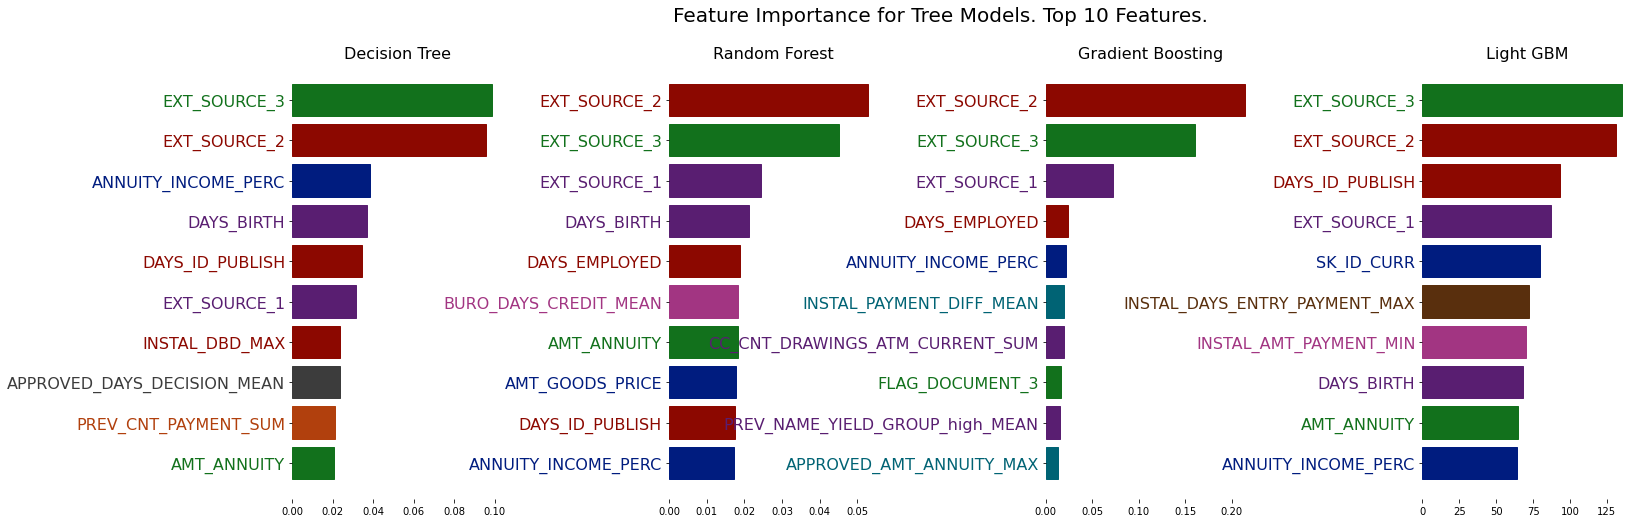

In [ ]:
#@title
# Create array of tree based models and plot feature importance scores
tree_models = []
#setup_plot()
color_list =  sns.color_palette("dark", len(features.columns)) 
top_x = 10 # number of x most important features to show
for model in trained_models:
  if hasattr(model["model"]["clf"], 'feature_importances_'): 
    tree_models.append({"name":model["name"], "fi": model["model"]["clf"].feature_importances_}) 
  

fig, axs = plt.subplots(1,4, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
  feature_importance = tree_models[i]["fi"]
  indices = np.argsort(feature_importance)
  indices = indices[-top_x:]

  bars = axs[i].barh(range(len(indices)), feature_importance[indices], color='b', align='center') 
  axs[i].set_title( tree_models[i]["name"], fontweight="normal", fontsize=16)

  plt.sca(axs[i])
  plt.yticks(range(len(indices)), [features.columns[j] for j in indices], fontweight="normal", fontsize=16) 

  # print(len(plt.gca().get_yticklabels()), len(indices))
  for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(color_list[indices[i]])  

  for i,bar in enumerate(bars):
    bar.set_color(color_list[indices[i]])
  plt.box(False)
  
plt.suptitle("Feature Importance for Tree Models. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal")
 

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

features = test_df.drop(['TARGET'], axis=1)
labels = test_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42) 

undersample = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

def get_lime_explainer(model, data, labels):  

  cat_feat_ix = [i for i,c in enumerate(data.columns) if pd.api.types.is_categorical_dtype(data[c])]
  feat_names = list(data.columns)
  class_names = list(labels.unique())
  scaler = model["model"]["scaler"]
  data = scaler.transform(data) # scale data to reflect train time scaling
  lime_explainer = LimeTabularExplainer(data,
                                      feature_names=feat_names,
                                      class_names=class_names,
                                      categorical_features=cat_feat_ix ,
                                      mode="classification"
                                      )
  return lime_explainer

def lime_explain(explainer, data, predict_method, num_features): 
  explanation = explainer.explain_instance(data, predict_method, num_features=num_features) 
  return explanation

lime_data_explainations = []
lime_metrics = []
lime_explanation_time = []
feat_names = list(features.columns)
test_data_index = 6
for current_model in trained_models:  
  scaler = current_model["model"]["scaler"]
  scaled_test_data = scaler.transform(X_test)
  predict_method = current_model["model"]["clf"].predict_proba 

  start_time = time.time()
  # explain first sample from test data
  lime_explainer = get_lime_explainer(current_model, X_train, y_train)
  explanation = lime_explain(lime_explainer, scaled_test_data[test_data_index], predict_method, top_x) 
  elapsed_time = time.time() - start_time 

  ex_holder = {}
  for feat_index,ex in explanation.as_map()[1] :
    ex_holder[feat_names[feat_index]] = ex
  
  lime_data_explainations.append(ex_holder) 
  actual_pred = predict_method(scaled_test_data[test_data_index].reshape(1,-1))
  perc_pred_diff =  abs(actual_pred[0][1] - explanation.local_pred[0])   
  lime_explanation_time.append({"time": elapsed_time, "model": current_model["name"] })
  lime_metrics.append({"lime class1": explanation.local_pred[0], "actual class1": actual_pred[0][1], "class_diff": round(perc_pred_diff,3), "model": current_model["name"] })
  # break 

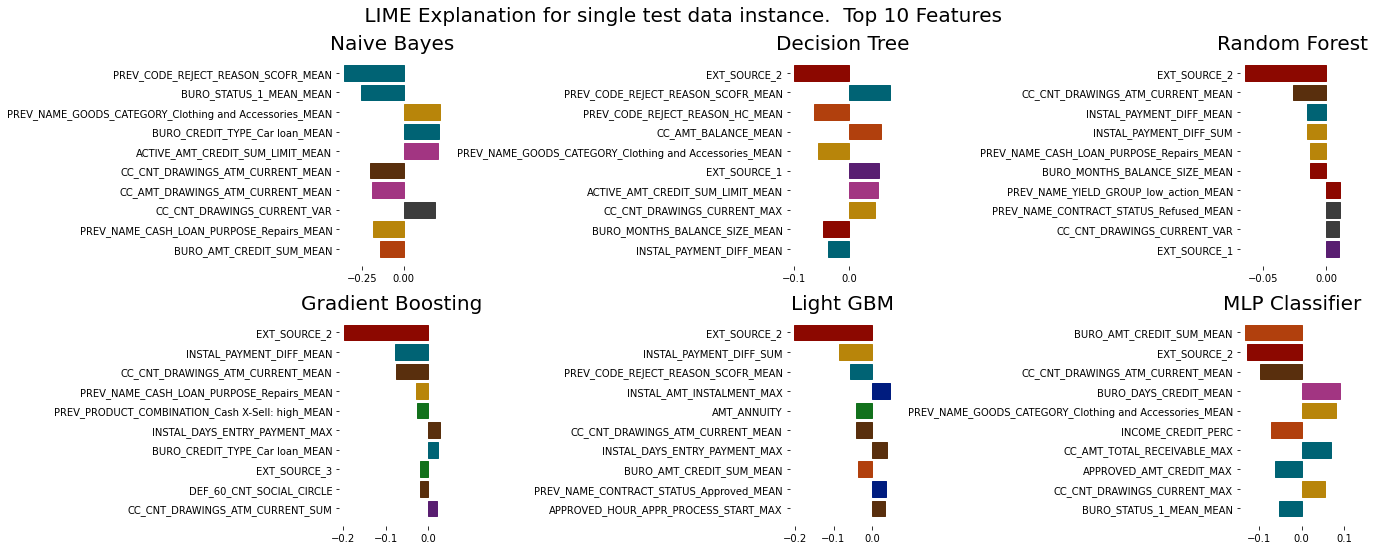

In [ ]:
def plot_lime_exp(fig, fig_index, exp_data, title):
  feature =  list(exp_data.keys())[::-1]
  explanations = list(exp_data.values())[::-1]
  ax = fig.add_subplot(fig_index) 
  lime_bar = ax.barh( feature, explanations ) 
  ax.set_title(title, fontsize = 20)
  for i,bar in enumerate(lime_bar):
    bar.set_color(color_list[list(features.columns).index(feature[i])])
    plt.box(False) 
fig = plt.figure(figsize=(19,8))

# Plot lime explanations for trained models
for i, dex in enumerate(lime_data_explainations):
  fig_index = "23" + str(i+1)
  plot_lime_exp(fig, fig_index, lime_data_explainations[i], trained_models[i]["name"])

plt.suptitle( " LIME Explanation for single test data instance.  Top " + str(top_x) + " Features", fontsize=20, fontweight="normal")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


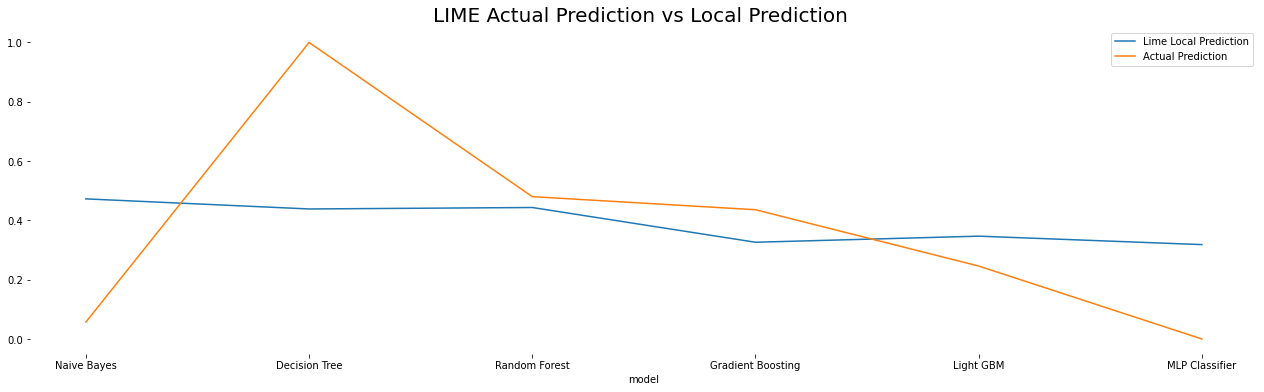

In [ ]:
# Plot run time for explanations
lime_metrics_df = pd.DataFrame(lime_metrics)  
lime_metrics_df_ax = lime_metrics_df[["lime class1", "actual class1", "model"]].plot(kind="line", x="model", title="LIME Actual Prediction vs Local Prediction ", figsize=(22,6))
lime_metrics_df_ax.title.set_size(20)
lime_metrics_df_ax.legend(["Lime Local Prediction", "Actual Prediction"])
plt.box(False)

Best ROC Score: 0.7601714147222773

Hyperparameter Tuning: {'max_depth': 88, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 678}


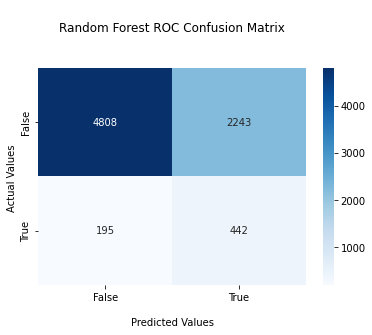


time taken:  406.0


In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix

time1 = time.time()

X = test_df.drop(['TARGET'], axis=1)
y = test_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

undersample = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Instantiate model
rfc = RandomForestClassifier(random_state=42)

# define the parameter space that will be searched over
param_distributions = {'n_estimators': randint(1, 1000),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': randint(1, 5),
                         'min_samples_split': randint(2, 10),
                         'max_depth': randint(1, 100)}

# now create a searchCV object and fit it to the data
search = RandomizedSearchCV(estimator=rfc,
                              n_iter=5, scoring="roc_auc", 
                              cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2),
                              param_distributions=param_distributions,
                              random_state=0)
  
y_pred = search.fit(X_train, y_train).predict(X_test)

Best_Score = search.best_score_
print('Best ROC Score:', Best_Score)          
Best_Params = search.best_params_
print('\nHyperparameter Tuning:', Best_Params)   

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('\nRandom Forest ROC Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

time2 = np.round(time.time() - time1,0)
print("\ntime taken: ", time2)

Best ROC Score: 0.7629695727851588

Hyperparameter Tuning: {'max_depth': 37, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 601}


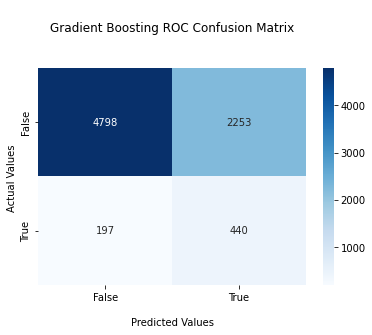


time taken:  1193.0


In [ ]:
time1 = time.time()

X = test_df.drop(['TARGET'], axis=1)
y = test_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

undersample = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

# Instantiate model
gbc = GradientBoostingClassifier(random_state=42)

# define the parameter space that will be searched over
param_distributions = {'n_estimators': randint(1, 1000),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': randint(1, 5),
                         'min_samples_split': randint(2, 10),
                         'max_depth': randint(1, 100)}

# now create a searchCV object and fit it to the data
search = RandomizedSearchCV(estimator=gbc,
                              n_iter=5, scoring="roc_auc", 
                              cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2),
                              param_distributions=param_distributions,
                              random_state=0)
  
y_pred = search.fit(X_train, y_train).predict(X_test)

Best_Score = search.best_score_
print('Best ROC Score:', Best_Score)         
Best_Params = search.best_params_
print('\nHyperparameter Tuning:', Best_Params)   

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('\nGradient Boosting ROC Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

time2 = np.round(time.time() - time1,0)
print("\ntime taken: ", time2)

Best Custom Score: 0.3082286277408229

Hyperparameter Tuning: {'clf__max_depth': 13, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 552}


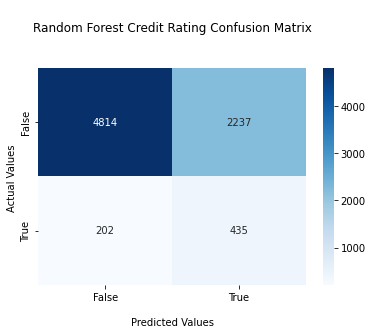


time taken:  414.0


In [ ]:
from sklearn.metrics import make_scorer

time1 = time.time()

labels = test_df['TARGET']
data = test_df.drop('TARGET', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)

undersample = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

def my_custom_loss_func(y_test, y_pred):
  CM = confusion_matrix(y_test, y_pred)
  CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
  FN = CM[1][0]
  FP = CM[0][1]
  credit_score = (((-10*FN) + (-1*FP))/11)
  return credit_score

my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False) 

pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())])

param_grid = {'clf__n_estimators': randint(1, 1000),
                         'clf__max_features': ['auto', 'sqrt'],
                         'clf__min_samples_leaf': randint(1, 5),
                         'clf__min_samples_split': randint(2, 10),
                         'clf__max_depth': randint(1, 100)}

search = RandomizedSearchCV(pipe, n_iter=5, scoring=my_scorer, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2),
                              param_distributions=param_grid, random_state=0)
    
y_pred = search.fit(X_train, y_train).predict(X_test)

Best_Score = search.best_score_
print('Best Custom Score:', Best_Score)          

Best_Params = search.best_params_
print('\nHyperparameter Tuning:', Best_Params)  

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('\nRandom Forest Credit Rating Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

time2 = np.round(time.time() - time1,0)
print("\ntime taken: ", time2)

Best Custom Score: 0.3171249602556206

Hyperparameter Tuning: {'clf__max_depth': 45, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 836}


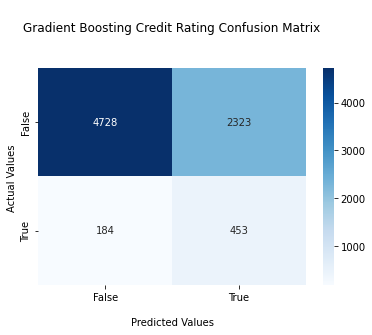


time taken:  1177.0


In [ ]:
from sklearn.metrics import make_scorer

time1 = time.time()

labels = test_df['TARGET']
data = test_df.drop('TARGET', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)

undersample = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = undersample.fit_resample(X_train, y_train)

def my_custom_loss_func(X_train, y_train):
    CM = confusion_matrix(y_test, y_pred)
    CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
    FN = CM[1][0]
    FP = CM[0][1]
    credit_score = (((-10*FN) + (-1*FP))/11)
    return credit_score

my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])

param_grid = {'clf__n_estimators': randint(1, 1000),
                         'clf__max_features': ['auto', 'sqrt'],
                         'clf__min_samples_leaf': randint(1, 5),
                         'clf__min_samples_split': randint(2, 10),
                         'clf__max_depth': randint(1, 100)}

search = RandomizedSearchCV(pipe, n_iter=5, scoring=my_scorer, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2),
                              param_distributions=param_grid, random_state=0)
    
y_pred = search.fit(X_train, y_train).predict(X_test)

Best_Score = search.best_score_
print('Best Custom Score:', Best_Score)          
Best_Params = search.best_params_
print('\nHyperparameter Tuning:', Best_Params)   

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('\nGradient Boosting Credit Rating Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

time2 = np.round(time.time() - time1,0)
print("\ntime taken: ", time2)

Best Custom Score: 0.3009336922020383

Hyperparameter Tuning: {'clf__max_depth': 13, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 552}


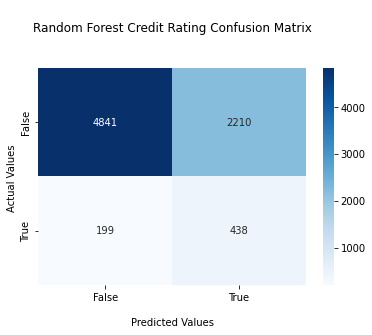


time taken:  629.0


In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.ensemble import BalancedRandomForestClassifier

time1 = time.time()

labels = test_df['TARGET']
data = test_df.drop('TARGET', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42)

def my_custom_loss_func(y_test, y_pred):
  CM = confusion_matrix(y_test, y_pred)
  CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
  FN = CM[1][0]
  FP = CM[0][1]
  credit_score = (((-10*FN) + (-1*FP))/11)
  return credit_score

my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False) 

pipe = Pipeline([('scaler', StandardScaler()), ('clf', BalancedRandomForestClassifier(sampling_strategy='all'))])

param_grid = {'clf__n_estimators': randint(1, 1000),
                         'clf__max_features': ['auto', 'sqrt'],
                         'clf__min_samples_leaf': randint(1, 5),
                         'clf__min_samples_split': randint(2, 10),
                         'clf__max_depth': randint(1, 100)}

search = RandomizedSearchCV(pipe, n_iter=5, scoring=my_scorer, cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2),
                              param_distributions=param_grid, random_state=0)
    
y_pred = search.fit(X_train, y_train).predict(X_test)

Best_Score = search.best_score_
print('Best Custom Score:', Best_Score)          

Best_Params = search.best_params_
print('\nHyperparameter Tuning:', Best_Params)  

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('\nRandom Forest Credit Rating Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix.
plt.show()

time2 = np.round(time.time() - time1,0)
print("\ntime taken: ", time2)

Machine Learning conclusion

Random Forests custom score = 0.31 in 422s for (splits = 5, repeats = 2)

Gradient Boosting custom score = 0.32 in 1255s (splits = 5, repeats = 2)

The two methods produce nearly the same score but random forests is much faster as this will be running as an API speed is very important. Therefore random forests is selected for API functions

# API Functions

In [ ]:
def Local_Data(test_df, Selected_Customer):

#Local Features Case for a chosen Selected Customer

  time1 = time.time()

  feature_list = list(test_df.columns)

  X = test_df.drop(['TARGET'], axis=1).values
  y = test_df['TARGET'].values

  data = Selected_Customer.drop(['TARGET'], axis=1).values

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  undersample = RandomUnderSampler(sampling_strategy=1)
  X_train, y_train = undersample.fit_resample(X_train, y_train)

  rfc = RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=552)

  score = rfc.fit(X_train, y_train).predict(data)

  Credit_given_test = np.max(rfc.predict_proba(data))

  if score==0:
    credit_score=Credit_given_test

  else:
    credit_score=(1-Credit_given_test)

  # Get numerical feature importances
  importances = list(rfc.feature_importances_)

  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  #Ten most important features
  ten_most_important = feature_importances[0:10]

  ten_most_important_df = pd.DataFrame(ten_most_important)

  ten_most_important_df.columns = ['Feature', 'Importance']

  ten_most_important_df['Credit Score'] = credit_score

  ten_most_important_df['Credit Granted?'] = None

  if credit_score>=0.35:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('Yes')
  elif credit_score>=0.25:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('Risky')
  else:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('No')

  # Print out the feature and importances 
  print(ten_most_important_df)

  time2 = np.round(time.time() - time1,0)
  print("\ntime taken: ", time2)

In [ ]:
def Local_Pickle_Data(test_df, Selected_Customer):

  time1 = time.time()

#Local Features Case for a chosen Selected Customer

  feature_list = list(test_df.columns)

  X = test_df.drop(['TARGET'], axis=1).values
  y = test_df['TARGET'].values

  data = Selected_Customer.drop(['TARGET'], axis=1).values

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  filename = '/content/drive/MyDrive/finalized_model.sav'

  loaded_model = pickle.load(open(filename, 'rb'))

  score = loaded_model.fit(X_train, y_train).predict(data)

  Credit_given_test = np.max(loaded_model.predict_proba(data))

  if score==0:
    credit_score=Credit_given_test

  else:
    credit_score=(1-Credit_given_test)

  # Get numerical feature importances
  importances = list(loaded_model.feature_importances_)

  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  #Ten most important features
  ten_most_important = feature_importances[0:10]

  ten_most_important_df = pd.DataFrame(ten_most_important)

  ten_most_important_df.columns = ['Feature', 'Importance']

  ten_most_important_df['Credit Score'] = credit_score

  ten_most_important_df['Credit Granted?'] = None

  if credit_score>=0.35:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('Yes')
  elif credit_score>=0.25:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('Risky')
  else:
    ten_most_important_df['Credit Granted?'] = ten_most_important_df['Credit Granted?'].fillna('No')

  # Print out the feature and importances 
  print(ten_most_important_df)

  time2 = np.round(time.time() - time1,0)
  print("\ntime taken: ", time2)

In [ ]:
Selected_Customer = test_df.loc[test_df['SK_ID_CURR'] == 100120]

In [ ]:
Local_Data(test_df, Selected_Customer)

                           Feature  Importance  Credit Score Credit Granted?
0                     EXT_SOURCE_3        0.08      0.257001           Risky
1  PREV_CODE_REJECT_REASON_HC_MEAN        0.06      0.257001           Risky
2                     EXT_SOURCE_2        0.03      0.257001           Risky
3                    DAYS_EMPLOYED        0.03      0.257001           Risky
4         DEF_30_CNT_SOCIAL_CIRCLE        0.02      0.257001           Risky
5         APPROVED_AMT_ANNUITY_MAX        0.02      0.257001           Risky
6                   INSTAL_DBD_MAX        0.02      0.257001           Risky
7          INSTAL_AMT_PAYMENT_MEAN        0.02      0.257001           Risky
8       INSTAL_AMT_INSTALMENT_MEAN        0.02      0.257001           Risky
9                  FLAG_DOCUMENT_3        0.02      0.257001           Risky

time taken:  8.0


In [ ]:
Local_Pickle_Data(test_df, Selected_Customer)

                           Feature  Importance  Credit Score Credit Granted?
0  PREV_CODE_REJECT_REASON_HC_MEAN        0.06      0.855852             Yes
1                     EXT_SOURCE_3        0.06      0.855852             Yes
2                     EXT_SOURCE_2        0.02      0.855852             Yes
3         DEF_60_CNT_SOCIAL_CIRCLE        0.02      0.855852             Yes
4                   INSTAL_DBD_MAX        0.02      0.855852             Yes
5          INSTAL_AMT_PAYMENT_MEAN        0.02      0.855852             Yes
6       INSTAL_AMT_INSTALMENT_MEAN        0.02      0.855852             Yes
7                  FLAG_DOCUMENT_3        0.02      0.855852             Yes
8                    DAYS_EMPLOYED        0.02      0.855852             Yes
9      BURO_MONTHS_BALANCE_MIN_MIN        0.02      0.855852             Yes

time taken:  57.0


In [ ]:
def Global_Data(test_df):

  #Global Features Case

  feature_list = list(test_df.columns)

  X = test_df.drop(['TARGET'], axis=1).values
  y = test_df['TARGET'].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  undersample = RandomUnderSampler(sampling_strategy=1)
  X_train, y_train = undersample.fit_resample(X_train, y_train)

  rfc = RandomForestClassifier(max_depth=13, min_samples_leaf=2, min_samples_split=8, n_estimators=552)

  rfc.fit(X_train, y_train)

  filename = '/content/drive/MyDrive/finalized_model.sav'
  pickle.dump(rfc, open(filename, 'wb'))

  # Get numerical feature importances
  importances = list(rfc.feature_importances_)

  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  #Ten most important features
  ten_most_important = feature_importances[0:10]

  ten_most_important_df = pd.DataFrame(ten_most_important)

  ten_most_important_df.columns = ['Feature', 'Importance']

  # Print out the feature and importances 
  print(ten_most_important_df)

In [ ]:
Global_Data(test_df)

                              Feature  Importance
0                        EXT_SOURCE_3        0.08
1     PREV_CODE_REJECT_REASON_HC_MEAN        0.07
2                        EXT_SOURCE_2        0.03
3                       DAYS_EMPLOYED        0.03
4            DEF_60_CNT_SOCIAL_CIRCLE        0.02
5  PREV_CODE_REJECT_REASON_SCOFR_MEAN        0.02
6            DEF_30_CNT_SOCIAL_CIRCLE        0.02
7            APPROVED_AMT_ANNUITY_MAX        0.02
8             INSTAL_PAYMENT_DIFF_SUM        0.02
9       INSTAL_DAYS_ENTRY_PAYMENT_MAX        0.02
